In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, SimpleDatasetMaker
from src.models import RecurrentSpaceNet

plt.style.use("figures/project_style.mplstyle")

In [2]:
def population_decoding(p, memory, r_memory):
    """Population decoding scheme: decode location as location r_memory 
       corresponding to most similar (closest) population vector in memory
       to current population vector p

    Args:
        p (N, n_p): population vectors to be decoded
        memory (M, n_p): memory of population vectors
        r_memory (M, 2): physical locations of memory vectors
    """
    dists = np.sum((p[None] - memory[:,None])**2, axis = -1) # (M, N)
    inds = np.argmin(dists, axis = 0) # (N)
    decoded_trajectories = r_memory[inds] #(N, 2)
    return decoded_trajectories

In [3]:
path = "./models/"
name = "256_075beta_0"

In [4]:
model = torch.load(f"{path}/{name}.pt")

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_26413/4009632865.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{path}/{name}.pt")


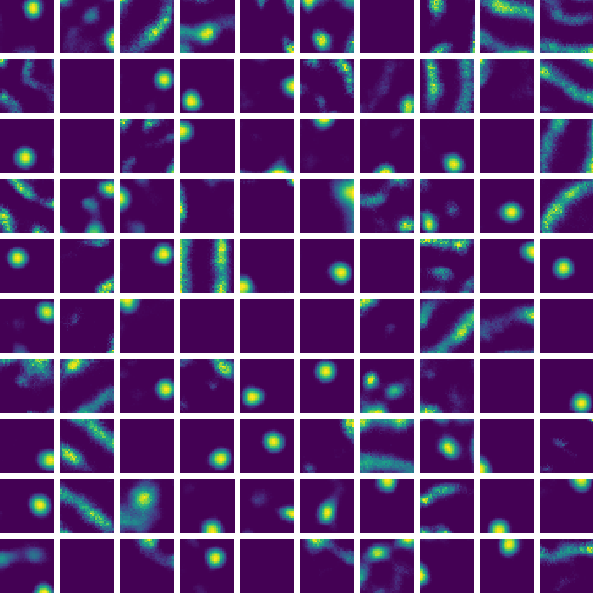

In [5]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
timesteps = 10
res = 32 # ratemap + memory resolution

genny = SimpleDatasetMaker() # use simple dataset
r, v = genny.generate_dataset(n_plot, timesteps)

# 'ere we go again
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, x, y, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = res)
fig, ax = ratemap_collage(ratemaps[:n_show], cols = int(np.sqrt(n_show)), figsize = (4,4))


In [6]:
# Form "memory" of population vectors: just use ratemaps
memory = ratemaps.reshape(model.n_out,-1).T

In [7]:
xx = x[:-1] + np.diff(x)/2 # midpoint of bins used for ratemaps
yy = y[:-1] + np.diff(y)/2
xx, yy = np.meshgrid(xx,yy)
r_memory = np.stack((yy.ravel(), xx.ravel()), axis =-1) # (square) grid of memory locations

In [8]:
# evaluate on unseen trajectories
n_eval = 256
t_eval = 20
r_eval, v_eval = genny.generate_dataset(n_eval, t_eval)
p_eval, _ = model.spatial_representation(v_eval, model.p0(r_eval[:,0])[None])
p_eval = p_eval.detach().numpy()

In [9]:
r_decoded = population_decoding(p_eval.reshape(-1, p_eval.shape[-1]), memory, r_memory) # beware, this is N^2 :O
r_decoded = r_decoded.reshape(p_eval.shape[0], p_eval.shape[1], 2) # 

(-1.0, 1.0, -1.0, 1.0)

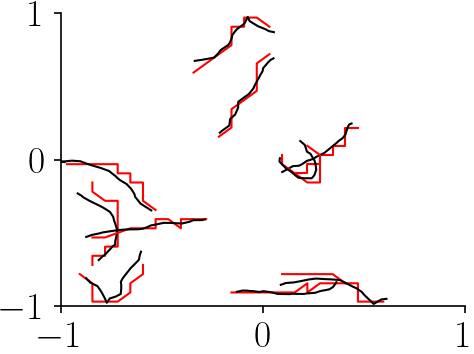

In [10]:
# plot some examples
for i in range(10):
    plt.plot(r_decoded[i,:, 0], r_decoded[i,:,1], "r")
    plt.plot(r_eval[i,:, 0], r_eval[i,:,1], "k")
plt.axis([-1, 1, -1, 1])

Text(0, 0.5, 'Decoding Error')

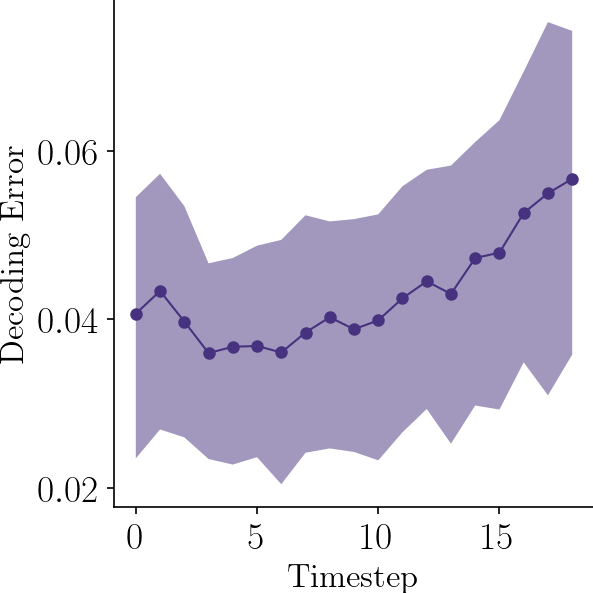

In [11]:
plt.figure(figsize=(4,4))

error = np.linalg.norm(r_eval[:,1:] - r_decoded, axis = -1)

error_quartiles = np.percentile(error, [25, 75], axis = 0)
plt.plot(np.mean(error, axis = 0),"-o", markersize = 5, label = "Population" )
plt.fill_between(np.arange(t_eval - 1), error_quartiles[0], error_quartiles[1], alpha = 0.5)

plt.xlabel("Timestep")
plt.ylabel("Decoding Error")